In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.int = int
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.multioutput import MultiOutputClassifier
import yaml
import wandb 
import random
import warnings
from sklearn.base import BaseEstimator
from sklearn.metrics import roc_auc_score
import pandas as pd
warnings.filterwarnings("ignore")

# Python scripts
from PTBXLModel import PTBXLModel
    
ID = "ecg_id"
GROUP = "patient_id"
FOLD = "strat_fold"
RANDOM_STATE = 2024 
N_JOBS = 8
HYPERPARAM_ITERATIONS = 50
FEATURE_METHOD = "3dfmmecg"
PROBLEM = "all"


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
X = pd.read_csv("../data/3dfmmecg_features.csv").sort_values(by="ecg_id")

In [11]:
X = pd.read_csv("../data/3dfmmecg_features.csv").sort_values(by="ecg_id")
train_idx = X.loc[X[FOLD] <= 8, "ecg_id"].values
val_idx = X.loc[X[FOLD] == 9, "ecg_id"].values
test_idx = X.loc[X[FOLD] == 10, "ecg_id"].values
extra_ids = X["ecg_id"]
print(X.shape)

DATASET = "../data/" + FEATURE_METHOD + "_features.csv"
X = pd.read_csv(DATASET).sort_values(by="ecg_id")
X = X[["ecg_id"] + [col for col in X.columns if col != "ecg_id"]]

# Fill missing ECG with NaN
new_ids = extra_ids[~extra_ids.isin(X["ecg_id"])]
new_rows = pd.DataFrame(new_ids, columns=["ecg_id"])
new_rows = new_rows.reindex(columns=X.columns, fill_value=pd.NA)
X = pd.concat([X, new_rows], ignore_index=True)

print(X.shape)
X.head()

(21799, 318)
(21799, 318)


,ecg_id,strat_fold,age,sex,height,weight,A_P_I_mean,A_P_I_std,A_Q_I_mean,A_Q_I_std,...,β_T_aVR_circmean,β_T_aVR_circstd,β_T_aVL_circmean,β_T_aVL_circstd,β_T_aVF_circmean,β_T_aVF_circstd,RR_mean,RR_std,HR_mean,HR_std
0,1,3,56.0,1,NaN,63.0,63.644417,17.746255,140.204135,16.215102,...,0.092604,0.089625,3.441853,0.175244,3.127213,0.097689,937.000000,15.964246,64.050366,1.087776
1,2,2,19.0,0,NaN,70.0,30.480021,19.242320,117.139372,18.539420,...,0.395953,0.195223,3.618928,0.157800,3.431155,0.521418,1271.333333,82.507373,47.362280,3.104412
2,3,5,37.0,1,NaN,69.0,52.808632,6.816969,93.192237,17.091079,...,NaN,NaN,NaN,NaN,NaN,NaN,940.222222,20.011108,63.840161,1.345999
3,4,3,24.0,0,NaN,82.0,61.791648,10.818636,223.413351,18.800768,...,0.074764,0.144950,3.348633,1.045292,3.165907,0.329886,806.000000,38.812369,74.595881,3.525347
4,5,4,19.0,1,NaN,70.0,29.571852,7.502069,77.724568,13.965687,...,6.242107,0.110389,4.931426,0.870782,3.000628,0.145071,905.200000,51.538120,66.478286,3.802364


In [12]:
X_train = X.loc[X["ecg_id"].isin(train_idx),:]
X_train = X_train.reset_index(drop=True)
X_train = X_train.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
print(X_train.shape)

X_val = X.loc[X["ecg_id"].isin(val_idx),:]
X_val = X_val.reset_index(drop=True)
X_val = X_val.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
print(X_val.shape)

X_test = X.loc[X["ecg_id"].isin(test_idx),:]
X_test = X_test.reset_index(drop=True)
X_test = X_test.loc[:, ~X.columns.isin([ID, GROUP, FOLD])]
print(X_test.shape)

X_test.head()

(17418, 316)
(2183, 316)
(2198, 316)


,age,sex,height,weight,A_P_I_mean,A_P_I_std,A_Q_I_mean,A_Q_I_std,A_R_I_mean,A_R_I_std,...,β_T_aVR_circmean,β_T_aVR_circstd,β_T_aVL_circmean,β_T_aVL_circstd,β_T_aVF_circmean,β_T_aVF_circstd,RR_mean,RR_std,HR_mean,HR_std
0,55.0,0,NaN,70.0,43.334161,21.738630,121.917515,11.501944,183.108123,17.767003,...,NaN,NaN,NaN,NaN,NaN,NaN,986.250000,37.178143,60.914117,2.354530
1,40.0,0,NaN,72.0,25.951758,9.653543,62.335745,46.305332,112.232459,22.330440,...,0.264043,0.082027,5.342301,0.196688,3.192042,0.074710,823.400000,17.689922,72.898496,1.546975
2,60.0,0,NaN,85.0,59.974063,6.148471,79.112269,21.795821,591.164568,44.630614,...,NaN,NaN,NaN,NaN,NaN,NaN,935.777778,11.766242,64.126802,0.806662
3,26.0,0,NaN,93.0,68.863126,13.030364,163.288319,12.444008,372.917501,74.195633,...,NaN,NaN,NaN,NaN,NaN,NaN,921.555556,31.189386,65.175050,2.253713
4,54.0,0,NaN,67.0,25.256052,7.262756,102.537903,11.585182,170.547214,32.472862,...,0.111737,0.119498,3.606660,0.205766,2.997148,0.115116,847.200000,13.733981,70.838200,1.142714


In [13]:
# Load labels
y = pd.read_csv(f"../data/y_{PROBLEM}.csv")
lh = y.copy().fillna(0)
# Because of versioning
y.iloc[:, 1:] = y.iloc[:, 1:].map(lambda x: 1 if not pd.isna(x) else 0)
y = y.reset_index(drop=True)

y_train = (
    y.loc[y["ecg_id"].isin(train_idx), :]
    .drop(columns="ecg_id")
    .reset_index(drop=True)
)
lh_train = (
    lh.loc[lh["ecg_id"].isin(train_idx), :]
    .drop(columns="ecg_id")
    .reset_index(drop=True)
)

y_test = ( 
    y.loc[y["ecg_id"].isin(test_idx), :]
    .drop(columns="ecg_id")
    .reset_index(drop=True)
)
lh_test = (
    lh.loc[lh["ecg_id"].isin(test_idx), :]
    .drop(columns="ecg_id")
    .reset_index(drop=True)
)

## OneR

In [14]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score
from tqdm import tqdm


def get_models(X_train, X_test, max_depth=1):

    model_scores = {}
    models = {}
    DEMO_VARS = ["age", "sex", "weight", "height"]
    X_train_3dfmm = X_train.loc[:, ~X_train.columns.isin(DEMO_VARS)]
    X_test_3dfmm = X_test.loc[:, ~X_test.columns.isin(DEMO_VARS)]
    for col in tqdm(y_test.columns):
        y_train_i = y_train[col]
        y_test_i = y_test[col]
        clf = DecisionTreeClassifier(
            max_depth=max_depth, class_weight="balanced", random_state=2024
        )
        clf.fit(X_train_3dfmm, y_train_i)

        # Save the model_train
        models[col] = clf

        # Predict using the fitted model_train
        y_pred_train = clf.predict(X_train_3dfmm)
        y_pred_test = clf.predict(X_test_3dfmm)

        # Calculate metrics for test set
        recall_test = recall_score(y_test_i, y_pred_test)
        SP_test = recall_score(y_test_i, y_pred_test, pos_label=0)
        roc_auc_test = roc_auc_score(y_test_i, y_pred_test)

        # Store the metrics in the dictionary
        model_scores[col] = {
            "AUC_test": roc_auc_test,
            "SE_test": recall_test,
            "SP_test": SP_test,
        }

    model_scores = dict(
        sorted(model_scores.items(), key=lambda item: item[1]["AUC_test"], reverse=True)
    )

    # Print the sorted results with 2 decimal places
    for label, scores in model_scores.items():
        print(f"Label: {label}")
        print(
            f"Test - AUC: {scores['AUC_test']:.2f}, Recall: {scores['SE_test']:.2f}, SP: {scores['SP_test']:.2f}"
        )
        print()

    return model_scores, models

In [15]:
columns_to_round = X_train.filter(regex='^(A_|M_)').columns
X_train[columns_to_round] = X_train[columns_to_round].round(0)
X_train.head()

,age,sex,height,weight,A_P_I_mean,A_P_I_std,A_Q_I_mean,A_Q_I_std,A_R_I_mean,A_R_I_std,...,β_T_aVR_circmean,β_T_aVR_circstd,β_T_aVL_circmean,β_T_aVL_circstd,β_T_aVF_circmean,β_T_aVF_circstd,RR_mean,RR_std,HR_mean,HR_std
0,56.0,1,NaN,63.0,64.0,18.0,140.0,16.0,305.0,21.0,...,0.092604,0.089625,3.441853,0.175244,3.127213,0.097689,937.000000,15.964246,64.050366,1.087776
1,19.0,0,NaN,70.0,30.0,19.0,117.0,19.0,365.0,23.0,...,0.395953,0.195223,3.618928,0.157800,3.431155,0.521418,1271.333333,82.507373,47.362280,3.104412
2,37.0,1,NaN,69.0,53.0,7.0,93.0,17.0,444.0,39.0,...,NaN,NaN,NaN,NaN,NaN,NaN,940.222222,20.011108,63.840161,1.345999
3,24.0,0,NaN,82.0,62.0,11.0,223.0,19.0,254.0,26.0,...,0.074764,0.144950,3.348633,1.045292,3.165907,0.329886,806.000000,38.812369,74.595881,3.525347
4,19.0,1,NaN,70.0,30.0,8.0,78.0,14.0,249.0,14.0,...,6.242107,0.110389,4.931426,0.870782,3.000628,0.145071,905.200000,51.538120,66.478286,3.802364


In [16]:
oner_scores1, models1 = get_models(X_train, X_test, max_depth=1)

100%|██████████| 71/71 [00:48<00:00,  1.46it/s]

Label: SVTAC
Test - AUC: 0.97, Recall: 1.00, SP: 0.94

Label: PSVT
Test - AUC: 0.97, Recall: 1.00, SP: 0.94

Label: RAO/RAE
Test - AUC: 0.96, Recall: 1.00, SP: 0.92

Label: PRC(S)
Test - AUC: 0.96, Recall: 1.00, SP: 0.91

Label: CRBBB
Test - AUC: 0.96, Recall: 1.00, SP: 0.91

Label: TRIGU
Test - AUC: 0.95, Recall: 1.00, SP: 0.89

Label: CLBBB
Test - AUC: 0.95, Recall: 0.96, SP: 0.93

Label: INJIN
Test - AUC: 0.94, Recall: 1.00, SP: 0.88

Label: LPFB
Test - AUC: 0.93, Recall: 1.00, SP: 0.86

Label: STACH
Test - AUC: 0.92, Recall: 0.90, SP: 0.95

Label: INJLA
Test - AUC: 0.91, Recall: 1.00, SP: 0.81

Label: 3AVB
Test - AUC: 0.90, Recall: 1.00, SP: 0.80

Label: AFIB
Test - AUC: 0.90, Recall: 0.92, SP: 0.87

Label: SBRAD
Test - AUC: 0.89, Recall: 0.97, SP: 0.81

Label: RVH
Test - AUC: 0.88, Recall: 0.83, SP: 0.92

Label: ISCAS
Test - AUC: 0.87, Recall: 1.00, SP: 0.74

Label: LAFB
Test - AUC: 0.86, Recall: 0.91, SP: 0.82

Label: ANEUR
Test - AUC: 0.86, Recall: 0.80, SP: 0.92

Label: BIGU
Te

In [17]:
oner_scores2, models2 = get_models(X_train, X_test, max_depth=2)

100%|██████████| 71/71 [01:28<00:00,  1.24s/it]

Label: PRC(S)
Test - AUC: 0.98, Recall: 1.00, SP: 0.97

Label: PSVT
Test - AUC: 0.98, Recall: 1.00, SP: 0.96

Label: 3AVB
Test - AUC: 0.97, Recall: 1.00, SP: 0.94

Label: RAO/RAE
Test - AUC: 0.97, Recall: 1.00, SP: 0.93

Label: CRBBB
Test - AUC: 0.96, Recall: 1.00, SP: 0.91

Label: CLBBB
Test - AUC: 0.95, Recall: 0.94, SP: 0.95

Label: SEHYP
Test - AUC: 0.93, Recall: 1.00, SP: 0.87

Label: 2AVB
Test - AUC: 0.93, Recall: 1.00, SP: 0.86

Label: AFIB
Test - AUC: 0.93, Recall: 0.89, SP: 0.96

Label: STACH
Test - AUC: 0.92, Recall: 0.90, SP: 0.95

Label: LPFB
Test - AUC: 0.91, Recall: 1.00, SP: 0.82

Label: SBRAD
Test - AUC: 0.89, Recall: 0.97, SP: 0.81

Label: PMI
Test - AUC: 0.89, Recall: 1.00, SP: 0.78

Label: RVH
Test - AUC: 0.88, Recall: 0.83, SP: 0.94

Label: BIGU
Test - AUC: 0.88, Recall: 0.88, SP: 0.89

Label: INJAS
Test - AUC: 0.88, Recall: 0.82, SP: 0.94

Label: LAFB
Test - AUC: 0.87, Recall: 0.94, SP: 0.80

Label: PVC
Test - AUC: 0.87, Recall: 0.89, SP: 0.85

Label: HVOLT
Test - 

In [18]:
model_train = PTBXLModel.load("../models/all_3dfmmecg_RandomForestClassifier.891.896.967.969.pkl")
oner_scoresrf = {}
y_test_pred_prob = model_train.predict_proba(X_test)
y_test_pred_prob.columns = y_test.columns
# Calculate metrics for model_train
for label in y_test.columns:
    roc_auc = roc_auc_score(y_test[label], y_test_pred_prob[label])
    recall = recall_score(y_test[label], (y_test_pred_prob[label] >= 0.5).astype(int))
    specificity = recall_score(y_test[label], (y_test_pred_prob[label] >= 0.5).astype(int), pos_label=0)
    oner_scoresrf[label] = {
        'AUC_test': float(roc_auc),
        'SE_test': float(recall),
        'specificity_test': float(specificity)
    }

In [19]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, recall_score
from tqdm import tqdm
from labels import DIAG2SUB, SUB2SUPER, FORM, RHYTHM

palette = {
    "CD": "#1583d1",
    "HYP": "#de5f04",
    "MI": "#d60b0b",
    "NORM": "#2e9c19",
    "STTC": "#720ec4",
}

semaphore_colors = {
    0.6: "#ff0000",  # Red
    0.7: "#de7504",  # Orange
    0.8: "#abab00",  # Yellow
    0.9: "#029909",  # Soft Green
    1.0: "#007007",  # Intense Green
}

def extract_decision_rule(clf):
    tree = clf.tree_
    feature = tree.feature[0]
    threshold = tree.threshold[0]
    rule = f"{clf.feature_names_in_[feature]} > {threshold:.3f}"
    return rule

classification_rules = {}
for label, clf in models1.items():
    rule = extract_decision_rule(clf)
    classification_rules[label] = rule

data = []
for label, rule in classification_rules.items():
    scores = oner_scores1[label]
    subclass = DIAG2SUB.get(label, "-")
    superclass = SUB2SUPER.get(subclass, "-")
    form_rhythm = "FORM" if label in FORM else "RHYTHM" if label in RHYTHM else ""
    data.append(
        [
            superclass,
            subclass,
            form_rhythm,
            label,
            rule,
        ]
    )

df = pd.DataFrame(
    data, columns=["Superclass", "Subclass", "Form/Rhythm", "Label", "Rule (oneR)"]
)

df[f"AUC (oneR)"] = df["Label"].map(
    lambda x: oner_scores1[x]["AUC_test"]
)
df[f"SE (oneR)"] = df["Label"].map(lambda x: oner_scores1[x]["SE_test"])
df[f"SP (oneR)"] = df["Label"].map(
    lambda x: oner_scores1[x]["SP_test"]
)

df[f"AUC (Tree)"] = df["Label"].map(
    lambda x: oner_scores2[x]["AUC_test"]
)
df[f"SE (Tree)"] = df["Label"].map(lambda x: oner_scores2[x]["SE_test"])
df[f"SP (Tree)"] = df["Label"].map(
    lambda x: oner_scores2[x]["SP_test"]
)


df[f"AUC (RF_all)"] = df["Label"].map(
    lambda x: oner_scoresrf[x]["AUC_test"]
)

columns_order = [
    "Superclass",
    "Subclass",
    "Form/Rhythm",
    "Label",
    "AUC (RF_all)",
    "Rule (oneR)",
    "AUC (oneR)",
    "AUC (Tree)",
    "SE (oneR)",
    "SE (Tree)",
    #"SE (RF_all)",
    "SP (oneR)",
    "SP (Tree)",
    #"SP (RF_all)",
]
df = df[columns_order]

df.sort_values(
    by=["Superclass", "Form/Rhythm", "AUC (oneR)"], ascending=False, inplace=True
)

def apply_semaphore(val):
    for threshold, color in semaphore_colors.items():
        if val <= threshold:
            return f"background-color: {color}"
    return "background-color: #ffffff"


metrics_columns = [
    col for col in df.columns if "AUC" in col or "SE" in col or "SP" in col
]
styled_df = df.style.applymap(apply_semaphore, subset=metrics_columns)


def color_superclass(val):
    color = palette.get(val, "#ffffff")
    return f"background-color: {color}"


styled_df = styled_df.applymap(color_superclass, subset=["Superclass"])

styled_df = styled_df.format({col: "{:.3f}" for col in metrics_columns})

styled_df.to_html("oneR_classifiers.html")

display(styled_df)

,Superclass,Subclass,Form/Rhythm,Label,AUC (RF_all),Rule (oneR),AUC (oneR),AUC (Tree),SE (oneR),SE (Tree),SP (oneR),SP (Tree)
9,STTC,STTC,FORM,NDT,0.910,A_T_V5_mean > 102.500,0.776,0.776,0.857,0.857,0.695,0.695
14,STTC,STTC,FORM,LNGQT,0.905,ω_T_mean > 0.214,0.742,0.789,0.818,1.000,0.665,0.578
11,STTC,STTC,FORM,DIG,0.878,A_P_aVR_mean > 32.500,0.717,0.755,0.556,0.667,0.878,0.843
10,STTC,NST_,FORM,NST_,0.823,ω_T_std > 0.031,0.654,0.654,0.494,0.494,0.815,0.815
37,STTC,ISCA,,ISCAS,0.930,A_T_V3_mean > 126.500,0.872,0.862,1.000,1.000,0.744,0.724
36,STTC,STTC,,ANEUR,0.917,β_R_V3_circmean > 1.009,0.861,0.858,0.800,1.000,0.921,0.716
29,STTC,ISCI,,ISCIL,0.886,β_T_II_circmean > 2.577,0.821,0.821,0.778,0.778,0.863,0.863
31,STTC,ISC_,,ISC_,0.943,β_T_V6_circmean > 2.331,0.760,0.760,0.641,0.641,0.879,0.879
27,STTC,ISCA,,ISCLA,0.842,A_T_aVR_mean > 72.500,0.753,0.824,0.846,0.846,0.659,0.801
23,STTC,ISCA,,ISCAL,0.915,β_T_I_circmean > 2.384,0.744,0.819,0.636,0.803,0.851,0.835


## Selected Pathologies

In [20]:
y_diag = pd.read_csv(f"../data/y_diag.csv")
lh_diag = y_diag.copy().fillna(0)
# Because of versioning
y_diag.iloc[:, 1:] = y_diag.iloc[:, 1:].map(lambda x: 1 if not pd.isna(x) else 0)
y_diag = y_diag.reset_index(drop=True)


lh_diag_train = (
    lh_diag.loc[lh_diag["ecg_id"].isin(train_idx), :]
    .drop(columns="ecg_id")
    .reset_index(drop=True)
)

X_train_healthy = X_train.loc[(lh_diag_train['NORM'] >= 80.0) & (lh_diag_train.drop(columns=['NORM']) == 0.0).all(axis=1),:]


In [32]:
(X_test["A_P_II_mean"] > 113.5).astype(int).values

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
def plot_decision_tree(class_name, models, X_train):
    DEMO_VARS = ["age", "sex", "weight", "height"]
    X_train_3dfmm = X_train.loc[:, ~X_train.columns.isin(DEMO_VARS)]
    if class_name in models:
        clf = models[class_name]
        plt.figure(figsize=(12, 8))
        plot_tree(
            clf,
            feature_names=X_train_3dfmm.columns,
            class_names=["NO", class_name],
            filled=True,
            impurity=False,
            proportion=True,
            label='all',
        )
        plt.show()
    else:
        print(f"No model_train found for class: {class_name}")

def compute_threshold(X_train_healthy, variable, threshold):
    variable_values = X_train_healthy[variable].dropna().values
    percentiles = np.percentile(variable_values, np.arange(0, 101, 1))
    closest_percentile = np.abs(percentiles - threshold).argmin()
    print(f"Var = {variable}, threshold = {threshold}, correspondant percentile = {closest_percentile}th")
    return closest_percentile

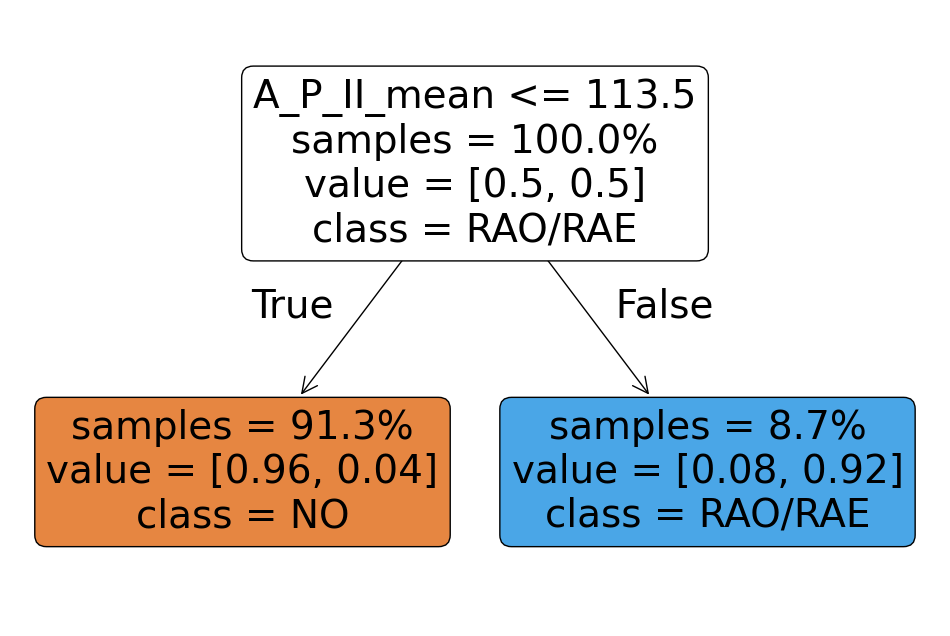

Var = A_P_II_mean, threshold = 113.62, correspondant percentile = 96th


In [26]:
plot_decision_tree("RAO/RAE", models1, X_train)
raorae_perc = compute_threshold(X_train_healthy, "A_P_II_mean", 113.62)

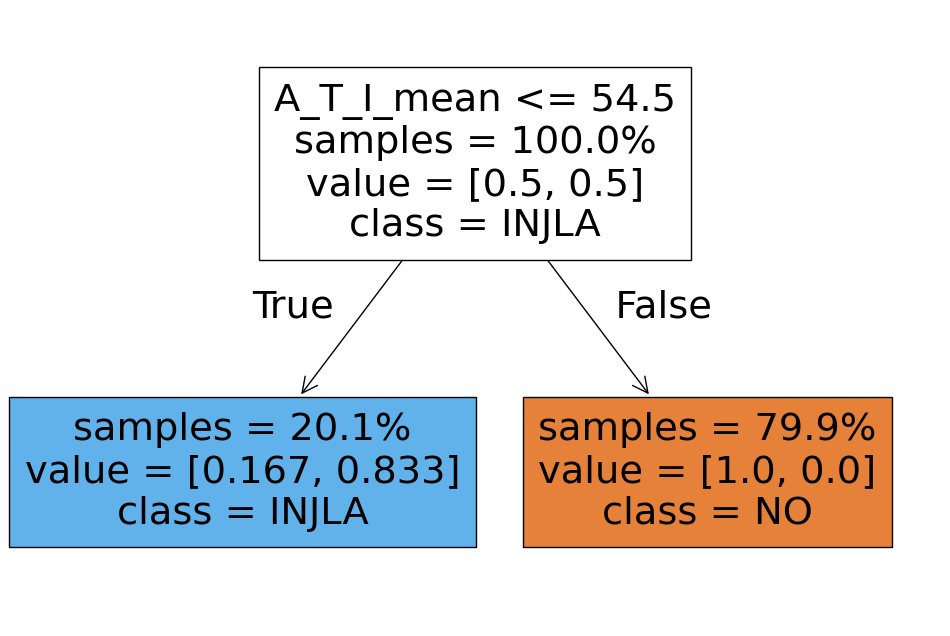

Var = A_T_I_mean, threshold = 53.612, correspondant percentile = 5th


In [23]:
plot_decision_tree("INJLA", models1, X_train)
injla_perc = compute_threshold(X_train_healthy, "A_T_I_mean", 53.612)

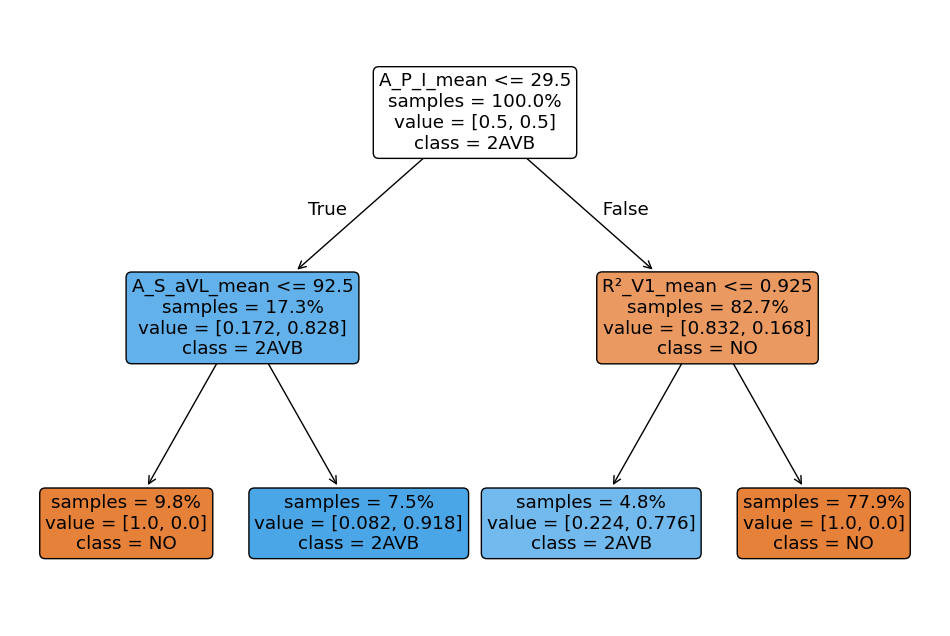

Var = A_P_I_mean, threshold = 28.769, correspondant percentile = 13th
Var = A_S_aVL_mean, threshold = 92.5, correspondant percentile = 61th
Var = R²_V1_mean, threshold = 0.925, correspondant percentile = 5th


In [27]:
plot_decision_tree("2AVB", models2, X_train)
avb2_perc1 = compute_threshold(X_train_healthy, "A_P_I_mean", 28.769)
avb2_perc2 = compute_threshold(X_train_healthy, "A_S_aVL_mean", 92.5)
avb2_perc3 = compute_threshold(X_train_healthy, "R²_V1_mean", 0.925)

## Feature selection

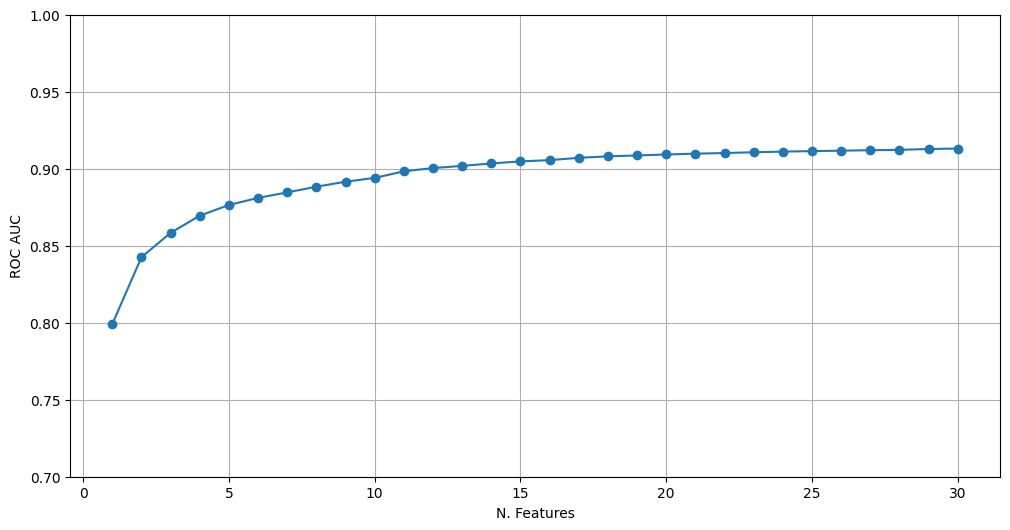

100%|██████████| 30/30 [03:47<00:00,  7.58s/it]


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [257]:
# Step 1: Importing necessary libraries
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output, display

from sklearn.datasets import load_iris

from tqdm import tqdm



X_train_glm = X_train.loc[:, ~X_train.columns.str.contains("β_|α_")]
X_test_glm = X_test.loc[:, ~X_test.columns.str.contains("β_|α_")]

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_glm.loc[:,:] = imputer.fit_transform(X_train_glm)
X_train_glm.loc[:,:] = scaler.fit_transform(X_train_glm)

X_test_glm.loc[:,:] = imputer.transform(X_test_glm)
X_test_glm.loc[:,:] = scaler.transform(X_test_glm)

y_train_abnormal = (1 - y_train["NORM"]).astype(int)
y_test_abnormal = (1 - y_test["NORM"]).astype(int)

num_features = []
auc_scores = []

selected_features = []

print("STARTING...")
N_ITER = 30

for k in tqdm(range(N_ITER)):
    best_auc = 0
    best_feature = None
    for feature in range(X_train_glm.shape[1]):
        if feature in selected_features:
            continue
        current_features = selected_features + [feature]

        X_train_const = sm.add_constant(X_train_glm[:, current_features])
        X_test_const = sm.add_constant(X_test_glm[:, current_features])

        try:
            model_train = sm.Logit(y_train_abnormal, X_train_const).fit(disp=0)
        except:
            continue
        # Predict and calculate the AUC score
        y_pred_prob = model_train.predict(X_test_const)
        auc = roc_auc_score(y_test_abnormal, y_pred_prob)

        if auc > best_auc:
            best_auc = auc
            best_feature = feature

    selected_features.append(best_feature)

    num_features.append(k + 1)
    auc_scores.append(best_auc)

    plt.figure(figsize=(12, 6))
    plt.plot(num_features, auc_scores, marker="o")
    plt.xlabel("N. Features")
    plt.ylabel("ROC AUC")

    plt.ylim([0.7, 1])
    plt.yticks(np.arange(0.7, 1.0, 0.05))
    plt.grid(True)

    if k < N_ITER:
        clear_output(wait=True)

    display(plt.gcf())
    plt.clf()

In [336]:
[round(x,3) for x in auc_scores]

[np.float64(0.799),
 np.float64(0.843),
 np.float64(0.858),
 np.float64(0.87),
 np.float64(0.876),
 np.float64(0.881),
 np.float64(0.885),
 np.float64(0.888),
 np.float64(0.892),
 np.float64(0.894),
 np.float64(0.898),
 np.float64(0.9),
 np.float64(0.902),
 np.float64(0.903),
 np.float64(0.905),
 np.float64(0.906),
 np.float64(0.907),
 np.float64(0.908),
 np.float64(0.909),
 np.float64(0.909),
 np.float64(0.91),
 np.float64(0.91),
 np.float64(0.911),
 np.float64(0.911),
 np.float64(0.911),
 np.float64(0.912),
 np.float64(0.912),
 np.float64(0.912),
 np.float64(0.913),
 np.float64(0.913)]

In [264]:
X_train_glm.iloc[:, selected_features].columns

Index(['A_T_aVR_mean', 'age', 'ω_R_mean', 'A_T_aVL_mean', 'A_R_III_mean',
       'ω_S_mean', 'A_S_aVR_mean', 'R²_V4_mean', 'A_T_V1_mean', 'M_III_mean',
       'A_T_aVF_mean', 'A_R_V5_std', 'dRP_mean', 'HR_mean', 'A_R_V3_mean',
       'A_S_V2_mean', 'A_T_V2_mean', 'M_V2_mean', 'R²_V5_std', 'A_Q_V4_mean',
       'A_R_II_mean', 'A_S_V3_mean', 'R²_V1_mean', 'A_T_V3_mean', 'M_V1_mean',
       'A_T_aVF_std', 'A_P_aVR_mean', 'A_Q_V6_std', 'dRT_std', 'ω_R_std'],
      dtype='object')

In [265]:
['A_T_aVR_mean', 'age', 'ω_R_mean', 'A_T_aVL_mean', 'A_R_III_mean',
       'ω_S_mean', 'A_S_aVR_mean', 'R²_V4_mean', 'A_T_V1_mean', 'M_III_mean',
       'A_T_aVF_mean', 'A_R_V5_std', 'dRP_mean', 'HR_mean', 'A_R_V3_mean',
       'A_S_V2_mean', 'A_T_V2_mean', 'M_V2_mean', 'R²_V5_std', 'A_Q_V4_mean',
       'A_R_II_mean', 'A_S_V3_mean', 'R²_V1_mean', 'A_T_V3_mean', 'M_V1_mean',
       'A_T_aVF_std', 'A_P_aVR_mean', 'A_Q_V6_std', 'dRT_std', 'ω_R_std']

['A_T_aVR_mean',
 'age',
 'ω_R_mean',
 'A_T_aVL_mean',
 'A_R_III_mean',
 'ω_S_mean',
 'A_S_aVR_mean',
 'R²_V4_mean',
 'A_T_V1_mean',
 'M_III_mean',
 'A_T_aVF_mean',
 'A_R_V5_std',
 'dRP_mean',
 'HR_mean',
 'A_R_V3_mean',
 'A_S_V2_mean',
 'A_T_V2_mean',
 'M_V2_mean',
 'R²_V5_std',
 'A_Q_V4_mean',
 'A_R_II_mean',
 'A_S_V3_mean',
 'R²_V1_mean',
 'A_T_V3_mean',
 'M_V1_mean',
 'A_T_aVF_std',
 'A_P_aVR_mean',
 'A_Q_V6_std',
 'dRT_std',
 'ω_R_std']

## SM Logit

In [12]:
import statsmodels.api as sm
import pandas as pd
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np

model_scores = {}

X_train_glm = X_train.copy()
X_test_glm = X_test.copy()

imputer = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_glm.loc[:, :] = imputer.fit_transform(X_train_glm)
X_train_glm.loc[:, :] = scaler.fit_transform(X_train_glm)

X_test_glm.loc[:, :] = imputer.transform(X_test_glm)
X_test_glm.loc[:, :] = scaler.transform(X_test_glm)

VARS_sm =['A_T_aVR_mean', 'age', 'ω_R_mean', 'A_T_aVL_mean', 'A_R_III_mean',
       'ω_S_mean', 'A_S_aVR_mean', 'R²_V4_mean', 'A_T_V1_mean', 'M_III_mean',
       'A_T_aVF_mean', 'A_R_V5_std', 'dRP_mean', 'HR_mean', 'A_R_V3_mean',
       'A_S_V2_mean', 'A_T_V2_mean', 'M_V2_mean', 'R²_V5_std', 'A_Q_V4_mean',
       'A_R_II_mean', 'A_S_V3_mean', 'R²_V1_mean', 'A_T_V3_mean', 'M_V1_mean',
       'A_T_aVF_std', 'A_P_aVR_mean', 'A_Q_V6_std', 'dRT_std', 'ω_R_std']


VARS_sm =['A_T_aVR_mean', 'age', 'ω_R_mean', 'A_T_aVL_mean', 'A_R_III_mean',
       'ω_S_mean', 'A_S_aVR_mean', 'R²_V4_mean', 'A_T_V1_mean', 'M_III_mean',
       'A_T_aVF_mean', 'dRP_mean', 'HR_mean', 'A_R_V3_mean',
       'A_S_V2_mean', 'A_T_V2_mean', 'M_V2_mean', 'R²_V5_std', 'A_Q_V4_mean',
       'A_R_II_mean', 'A_S_V3_mean', 'R²_V1_mean', 'A_T_V3_mean', 'M_V1_mean',
       'A_T_aVF_std', 'A_P_aVR_mean', 'A_Q_V6_std', 'dRT_std', 'ω_R_std']


VARS = VARS_sm[0:12]

X_train_glm = X_train_glm[VARS]
X_test_glm = X_test_glm[VARS]

label = "NORM"

y_train_abnormal = (1 - y_train["NORM"]).astype(int)
y_test_abnormal = (1 - y_test["NORM"]).astype(int)

X_train_glm = sm.add_constant(X_train_glm).astype(float)
X_test_glm = sm.add_constant(X_test_glm).astype(float)

model_train = sm.Logit(y_train_abnormal, X_train_glm).fit(disp=0)

y_test_pred_prob = model_train.predict(X_test_glm)
roc_auc = roc_auc_score(y_test_abnormal, y_test_pred_prob)
print(f"ROC AUC: {roc_auc:.3f}")
print(model_train.summary())

ROC AUC: 0.900
                           Logit Regression Results                           
Dep. Variable:                   NORM   No. Observations:                17418
Model:                          Logit   Df Residuals:                    17405
Method:                           MLE   Df Model:                           12
Date:                Mon, 21 Oct 2024   Pseudo R-squ.:                  0.4265
Time:                        12:46:42   Log-Likelihood:                -6842.0
converged:                       True   LL-Null:                       -11931.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.1176      0.034     32.668      0.000       1.051       1.185
A_T_aVR_mean    -1.9427      0.051    -38.003      0.000      -2.043      -1.843
age              0.5452      

In [13]:
# X_all_glm = X.copy()
# X_all_glm.loc[:, :] = imputer.fit_transform(X_all_glm)
# X_all_glm.loc[:, :] = scaler.fit_transform(X_all_glm)
# X_all_glm = X_all_glm[VARS]
# X_all_glm = sm.add_constant(X_all_glm).astype(float)

# y_all_abnormal = (1 - y["NORM"]).astype(int)

# model_refit = sm.Logit(y_all_abnormal, X_all_glm).fit(disp=0)

# print(model_refit.summary())

### OR

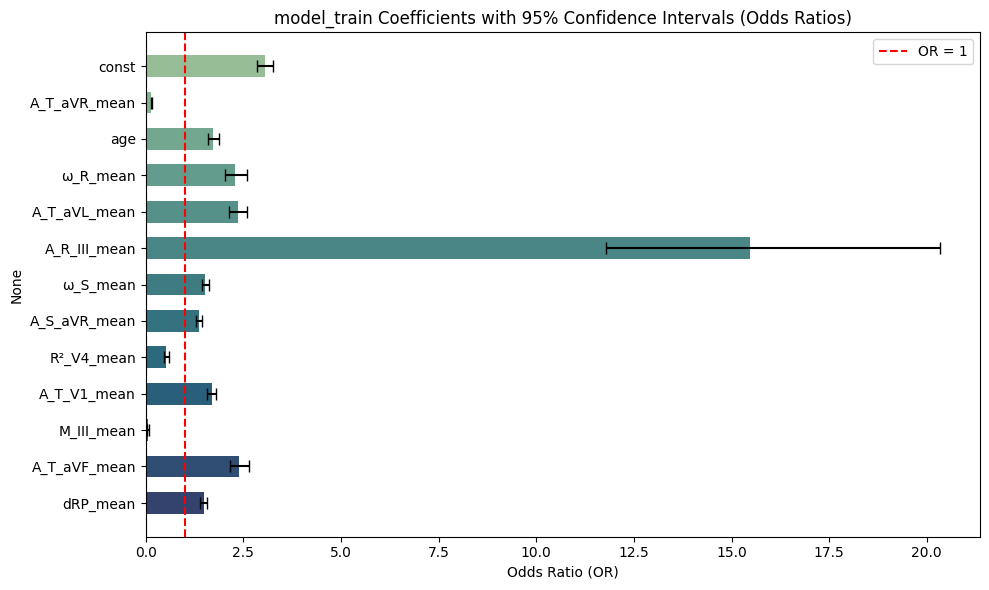

In [14]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

coefficients = model_train.params
conf = model_train.conf_int()
conf['OR'] = np.exp(coefficients)
conf.columns = ['2.5%', '97.5%', 'OR']
conf['2.5%'] = np.exp(conf['2.5%'])
conf['97.5%'] = np.exp(conf['97.5%'])

plt.figure(figsize=(10, 6))
sns.barplot(x=conf['OR'], y=conf.index, palette='crest', capsize=.2, width=.6)


plt.errorbar(conf['OR'], conf.index, 
             xerr=[conf['OR'] - conf['2.5%'], conf['97.5%'] - conf['OR']], 
             fmt='none', c='black', capsize=4)

# Add reference line for OR = 1 (no effect)
plt.axvline(1, color='red', linestyle='--', label='OR = 1')

# Customize plot
plt.title('model_train Coefficients with 95% Confidence Intervals (Odds Ratios)')
plt.xlabel('Odds Ratio (OR)')
plt.legend()
plt.tight_layout()
plt.show()


### Linearity

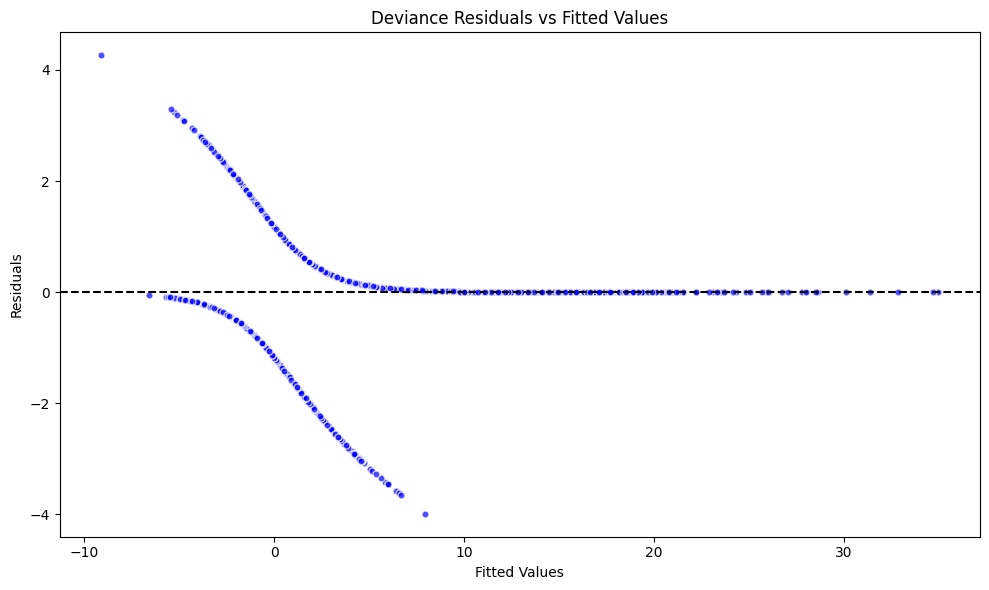

In [15]:
# 5. Residuals vs Fitted Plot
fitted_values = model_train.fittedvalues
residuals = model_train.resid_dev


plt.figure(figsize=(10, 6))
plt.plot(
    fitted_values,
    residuals,
    marker="o",
    linestyle="none",
    alpha=0.7,
    markersize=5,
    color="w",
    markerfacecolor="blue",
)
# sns.regplot(x=fitted_values, y=residuals, scatter=False, lowess=True, color='red')
plt.axhline(0, color="black", linestyle="--")
plt.title("Deviance Residuals vs Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")

plt.tight_layout()
plt.show()

### Multicollinearity

         Feature        VIF
0          const   1.000000
1   A_T_aVR_mean   1.629228
2            age   1.117581
3       ω_R_mean   1.763266
4   A_T_aVL_mean   1.499176
5   A_R_III_mean  11.640026
6       ω_S_mean   1.214960
7   A_S_aVR_mean   1.117233
8     R²_V4_mean   1.162932
9    A_T_V1_mean   1.379373
10    M_III_mean  11.424640
11  A_T_aVF_mean   1.430682
12      dRP_mean   1.329598


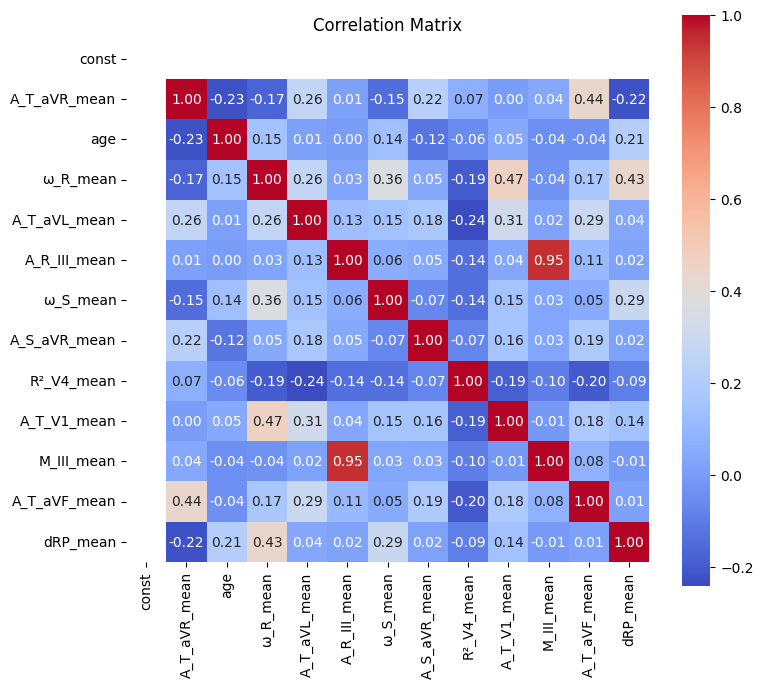

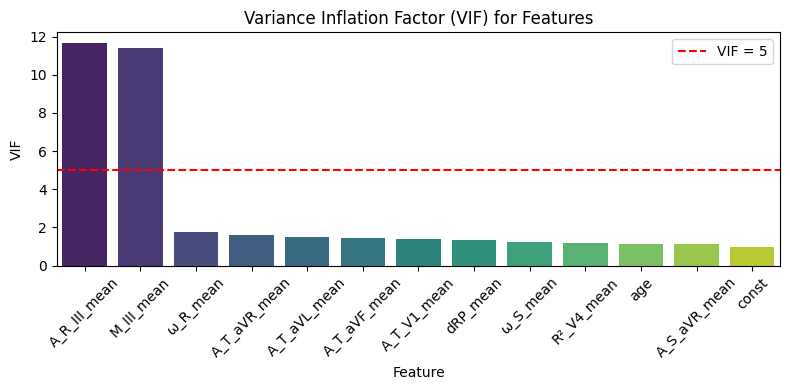

In [16]:
# 2. Correlation matrix and VIF matrix
vif_data = pd.DataFrame()
vif_data['Feature'] = X_train_glm.columns
vif_data['VIF'] = [variance_inflation_factor(X_train_glm, i) for i in range(X_train_glm.shape[1])]
print(vif_data)
# Plot correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(X_train_glm.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot VIF matrix
plt.figure(figsize=(8, 4))
sns.barplot(x='Feature', y='VIF', data=vif_data.sort_values(by='VIF', ascending=False), palette='viridis')
plt.axhline(5, color='red', linestyle='--', label='VIF = 5')
plt.title('Variance Inflation Factor (VIF) for Features')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

### Normality

ShapiroResult(statistic=np.float64(0.9971015671002664), pvalue=np.float64(7.621120998223623e-18))


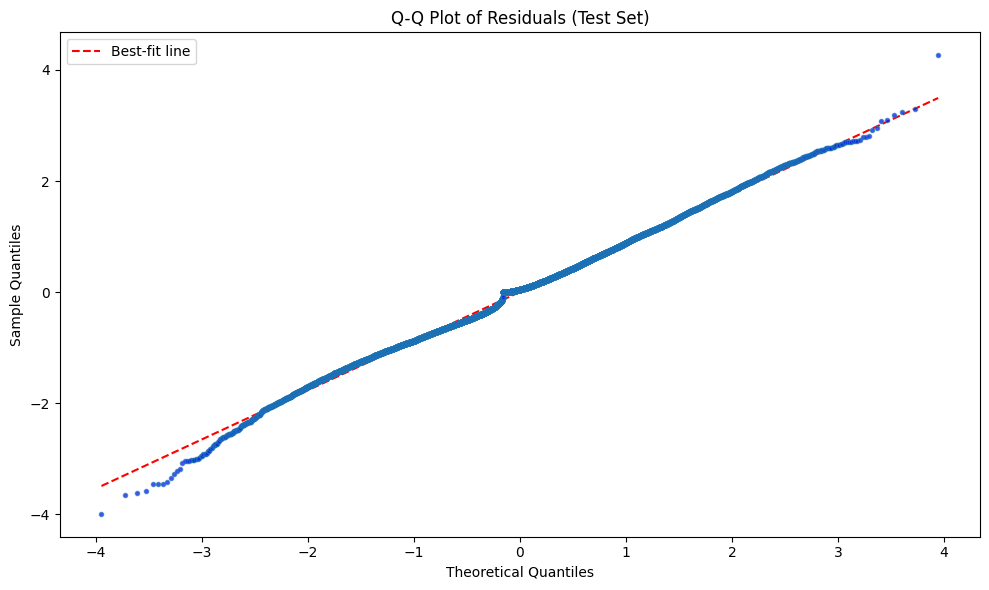

In [17]:

print(stats.shapiro(residuals.dropna()))
qq = stats.probplot(residuals.dropna(), dist="norm", plot=None)
plt.show()

plt.figure(figsize=(10, 6))
# Fit a line manually and plot it in red
slope, intercept = np.polyfit(qq[0][0], qq[0][1], 1)
plt.plot(
    qq[0][0],
    intercept + slope * qq[0][0],
    color="red",
    linestyle="--",
    label=f"Best-fit line",
)

plt.plot(
    qq[0][0],
    qq[0][1],
    marker="o",
    linestyle="none",
    alpha=0.7,
    markersize=3,
    #color="w",
    markerfacecolor="blue",
)


# Customizing the plot
plt.title("Q-Q Plot of Residuals (Test Set)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.legend()

plt.tight_layout()
plt.show()

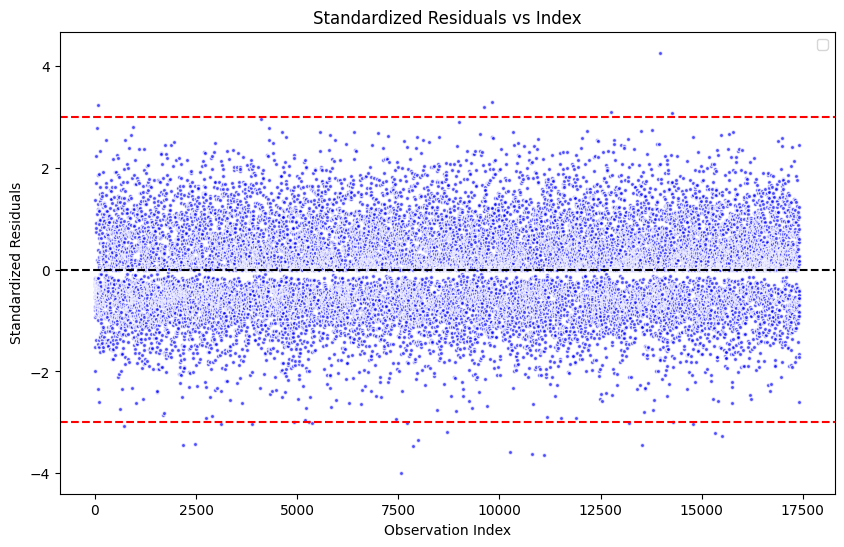

Outliers with residuals > 3: 25 (0.144%)


In [18]:
# Plot Standardized Residuals vs Index
plt.figure(figsize=(10, 6))
plt.plot(
    np.arange(len(residuals)),
    residuals,
    marker="o",
    linestyle="none",
    alpha=0.7,
    markersize=3,
    color="w",
    markerfacecolor="blue",
)
plt.axhline(0, color="black", linestyle="--")

plt.axhline(3, color="red", linestyle="--")
plt.axhline(-3, color="red", linestyle="--")

plt.xlabel("Observation Index")
plt.ylabel("Standardized Residuals")
plt.title("Standardized Residuals vs Index")
plt.legend()
plt.show()

# Highlight points with high standardized residuals
outliers = np.where(np.abs(residuals) > 3)[0]
print(f"Outliers with residuals > 3: {len(outliers)} ({len(outliers)/len(residuals)*100:.3f}%)")